# Semi-automatization of DRN and SFR sensitivity analysis/calibration

**Worflow**\
**DRN**
1. Load .drn file - *completed*
2. Change the conductance of the cells - *completed*
3. Write the .drn file - *completed*
4. Run the model - *completed*
5. Read .cbb file - *completed*
6. Store the outflow data of the first X cells - *completed*
7. Put the process in a loop over a range of parameters - *completed*: result in `DRN_SA.py`

**SFR**
1. Load .sfr file - *completed*
2. Change the hydraulic conductivity of the cells - *completed*
3. Write the .sfr file - *completed*
4. Run the model - *completed*
5. Read streamflow.dat file - *completed*
6. Store the flux data of cell at reach X - *completed*
7. Put the process in a loop over a range of parameters - *completed*: result in `SFR_SA.py`

## Setup

In [2]:
import flopy
import flopy.utils.binaryfile as bf
import glob
import numpy as np
import os
import pandas as pd

In [3]:
cwd = os.getcwd()

In [4]:
def change_type(df, cols, t):
    """
    Change the dtype of selected columns to a given type

    df: pandas.DataFrame
        the dataframe
    cols: str, list of str
        the columns to be changed
    t: str
        the dtype wanted

    Returns:
    df: pandas.DataFrame
    """
    for col in cols:
        df[col] = df[col].astype(t)
    return df

def load_drn_file(path):
    """
    Load MODFLOW .drn input file

    path: str
        Path to the .drn file to be loaded
    
    Returns:
    df: pandas.DataFrame
        Dataframe containing the information stored in the original .drn file
    """
    f = open(path).readlines()
    df = pd.DataFrame()
    for row in f[4:]:
        r = list(filter(None, row.split(' ')))
        df = pd.concat([df, pd.DataFrame(r).transpose()])
    df.columns = ['layer', 'row', 'column', 'stage', 'conductance', 'node']
    df.node = df.node.str.removesuffix('\n')
    df.reset_index(inplace=True, drop = True)

    # assign the correct dtypes to the functions
    df = change_type(df, ['layer', 'row', 'column'], 'int')
    df = change_type(df, ['stage', 'conductance', 'node'], 'float')    
    return df

def load_streamflow_dat(f, nsp = 1):
    """
    Load the streamflow.dat file generated as output by MODFLOW

    f: str
        path to the streamflow.dat file
    nsp: int, optional
        number of stress periods of the simulation. 1 works also with stationary models.
        Default is 1
    
    Returns:
    df: pandas.DataFrame
        dataframe containing the information stored inside streamflow.dat file
    """
    if nsp == 1:
        df = pd.DataFrame()
        with open(f, 'r') as file:
            for row in file.readlines()[8:]:
                r = list(filter(None, row.split(' ')))
                df = pd.concat([df, pd.DataFrame(r).transpose()])
            df.columns = ['l', 'r', 'c', 'iseg', 'ireach', 'flow_into_reach', 'flow_to_aquifer', 'flow_out_reach', 'overlnd_runoff',
                        'direct_precip', 'stream_et', 'stream_head', 'stream_depth', 'stream_width', 'streambed_cond', 'streambed_gradient']
            df.streambed_gradient = df.streambed_gradient.str.removesuffix('\n')
            df = change_type(df, ['l', 'r', 'c', 'iseg', 'ireach'], 'int') 
            df = change_type(df, ['flow_into_reach', 'flow_to_aquifer', 'flow_out_reach', 'overlnd_runoff',
                                    'direct_precip', 'stream_et', 'stream_head', 'stream_depth', 'stream_width',
                                    'streambed_cond', 'streambed_gradient'], 'float')
            df.reset_index(inplace = True, drop= True)
    else:
        for sp in range(nsp):
            pass
    return df

## DRAIN

### Load .drn file

In [5]:
# Load .drn file
drn = load_drn_file(os.path.join(cwd, 'test_files', 'busca_drain.drn'))
drn.head()

,layer,row,column,stage,conductance,node
0,1,46,51,124.838,0.012,0.0
1,1,47,51,124.835,0.018,0.0
2,1,48,51,124.832,0.006,0.0
3,1,48,52,124.830,0.024,0.0
4,1,49,52,124.824,0.018,0.0


In [6]:
# Load DRAIN cells characteristics
drn_sp = pd.read_csv(os.path.join(cwd, 'test_files', 'busca_drain_specifiche_celle.csv'))

In [7]:
drn_sp.head()

,row,column,layer,node,Reach,Stage,Conductanc,Width,Length,Thickness,K,Flux_gw
0,46,51,1,0,100,124.837925,0.012,3.0,2.0,0.5,0.001,-0.003902
1,47,51,1,0,100,124.835267,0.018,3.0,3.0,0.5,0.001,-0.005325
2,48,51,1,0,100,124.832472,0.006,3.0,1.0,0.5,0.001,-0.001696
3,48,52,1,0,100,124.829516,0.024,3.0,4.0,0.5,0.001,-0.006330
4,49,52,1,0,100,124.824446,0.018,3.0,3.0,0.5,0.001,-0.004554


In [8]:
# Compute the conductance of each cell for a given hydraulic conductivity
# Change the conductance column
k = 0.00001444444444444 #hydraulic conductivity
conductance_change = (k*drn_sp.Width*drn_sp.Length)/drn_sp.Thickness
drn.conductance = conductance_change

#### Multi-parameter change (two k values)

In [9]:
row_limit = 92
column_limit = 76

kt = 10000
ka = 90000

cond = (drn_sp.row <= row_limit) & (drn_sp.column <= column_limit)
drn_sp.loc[cond, 'Conductanc'] = (kt*drn_sp.loc[cond, 'Width']*drn_sp.loc[cond, 'Length'])/drn_sp.loc[cond, 'Thickness']
drn_sp.loc[~cond, 'Conductanc'] = (ka*drn_sp.loc[~cond, 'Width']*drn_sp.loc[~cond, 'Length'])/drn_sp.loc[~cond, 'Thickness']
drn.conductance = drn_sp.Conductanc

### Write .drn file using flopy

**bug found:** the layer gets put equal to 2 instead of 1
- the problem is not in the stress_period_data table passed to drn
- check stress_period_data.write_transient method
- couldn't figure it out, so found a way out: set drn.layer = 0
- drn_input_file_test_v4.drn works

In [8]:
modelpth = os.path.join(cwd, 'test_files')

# create the model class (only useful because it's needed by ModflowDrn class)
# this can be replaced by loading the actual model .nam file (not needed though)
mf = flopy.modflow.Modflow(
     "drn_test",
    model_ws = modelpth,
    exe_name = "mf2005",
)

In [ ]:
# transform the drn structure in the flopy required format for "stress_period_data"
# flopy adds 1 to layer, row and column, so subtract 1 to them
drn.layer = drn.layer - 1
drn.row = drn.row - 1
drn.column = drn.column - 1
stress_period_data = {0: drn.iloc[:, :-1].to_numpy().tolist()} #remove node column, not needed nor supported by flopy's ModflowDrn class

In [10]:
#generate the drn package inside the flopy class
ipakcb = 50 #code for cell-by-cell flow data storage
drain = flopy.modflow.ModflowDrn(mf, ipakcb=ipakcb, stress_period_data=stress_period_data,
                                 filenames=os.path.join(cwd, 'test_files', 'drn_input_file_test_v5.drn'))
drain.write_file(check = False)

### Test: Run the model

In [ ]:
# trial: run from flopy

# load the existing model busca_drain
# https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mf.html

mf = flopy.modflow.Modflow.load(
        os.path.join(cwd, 'test_files', 'drain_model_test', 'busca_drain.nam'),
        model_ws = os.path.join(cwd, 'test_files', 'drain_model_test'),
        exe_name='MF2005',
        version = 'mf2005',
        verbose = False
        )

In [ ]:
# drn stress period data can be accessed by:
mf.drn.stress_period_data.data

In [ ]:
# this works
success, buff = flopy.mbase.run_model(
                exe_name = os.path.join(cwd, 'test_files', 'drain_model_test','MF2005.exe'),
                namefile = 'busca_drain.nam',
                model_ws = os.path.join(cwd, 'test_files', 'drain_model_test')
                )
if not success:
    raise Exception("MODFLOW did not terminate normally.")

### Read .cbb output file

class CellBudgetFile\
https://flopy.readthedocs.io/en/latest/source/flopy.utils.binaryfile.html

The outflow will have to be considered until cell:
- row 92, column 76 (last cell of first segment)
Check if any substantial change in outflow happen if considering:
- row 93, column 76 (first cell of second segment)

In [10]:
#get drain values from cbb output
cbb = bf.CellBudgetFile(os.path.join(cwd, 'test_files', 'drain_model_test', 'busca_drain.cbb'))
drain = cbb.get_data(text = 'DRAINS')

# get all the cells until 92, 76 & sum the flux extracted from drain[0]
row_limit = 92
column_limit = 76
sum_drain = np.sum(drain[0][0, :row_limit+1, :column_limit+1])
sum_drain

np.float32(-0.061737195)

#### Get all drain cells

In [11]:
drain_outflow = []
for r,c in zip(drn.row, drn.column):
    drain_outflow.append(drain[0][0, r, c])

<Axes: >

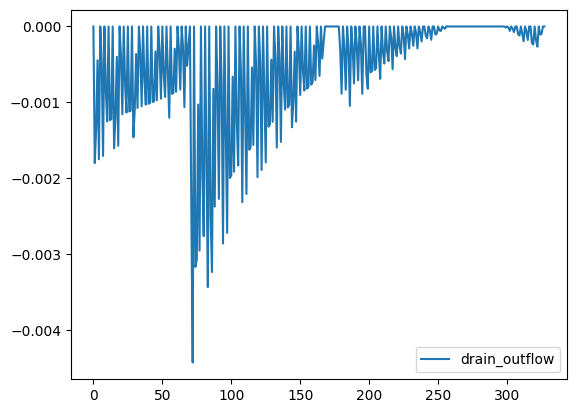

In [12]:
pd.DataFrame({'r': drn.row, 'c': drn.column, 'drain_outflow': drain_outflow}).plot(y='drain_outflow')

## SFR

### Load SFR characteristics and write new .sfr file

The .sfr file is multi structured:
- the above section has a structure similar to .drn
- in the last section, the structure is different: there is the info about the segments
- width and manning coefficient are defined in the segment section
- length, slope, bed thickness and bed hydraulic conductivity are defined in the first section\
try to use flopy to load the model and then modify the sfr parameters directly from there

I had issues in loading the .sfr file through **ModflowSfr2.load()**\
- the file was structured as SFR2 input file, and the function didn't recognize it
- so we changed the input file structure to SFR1 from GWV
- this however lost the information on slope associated to all reaches\

So, this was the workaround found:
- from the .sfr file, the reach data, segment data and the other items where copied in a dedicated Excel file, each on a sheet
- the data is loaded as pandas.DataFrame/numpy.ndarray
- the data is passed to the ModflowSfr2 class in flopy which then handles the writing of the sfr input file

Once the file is loaded through ModflowSfr2.load(), it contains, among other things:
- **sfr.reach_data**: access the characteristics of the reaches
- **sfr.segment_data**: access the characteristics of the segments

Resources used:
1. https://flopy.readthedocs.io/en/stable/Notebooks/mf6_sfr_tutorial01.html
2. https://flopy.readthedocs.io/en/stable/Notebooks/sfrpackage_example.html

In [12]:
# check the available items in the excel file
xls = pd.ExcelFile(os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx'))
items = xls.sheet_names
items

['ITEM1', 'ITEM2', 'ITEM5', 'ITEM6a', 'ITEM6abc', 'ITEM6b', 'ITEM6c']

In [13]:
# load general parameters (item 1)
it1 = pd.read_excel(os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx'), sheet_name = 'ITEM1')

# load reach data (item 2)
reach_data = pd.read_excel(os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx'), sheet_name = 'ITEM2')
reach_data = reach_data.apply(pd.to_numeric)
reach_data.columns = ['k', 'i', 'j', 'iseg', 'ireach', 'rchlen', 'strtop', 'slope',  'strthick',  'strhc1']
reach_data = reach_data.loc[:,:].to_records(index = False)
# flopy adds 1 to layer, row and column, so remove 1 here
reach_data.k = reach_data.k - 1
reach_data.i = reach_data.i - 1
reach_data.j = reach_data.j - 1

# load item 5
it5 = pd.read_excel(os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx'), sheet_name = 'ITEM5')

# load segment data (item 6a)
segment_data = pd.read_excel(os.path.join(cwd, 'test_files', 'busca_sfr2_sfr_data.xlsx'), sheet_name = 'ITEM6abc')
segment_data.columns = [x.lower() for x in segment_data.columns]
segment_data = segment_data.loc[:,:].to_records(index = False)
segment_data = {0: segment_data}

In [14]:
# modify k
reach_data.strhc1 = 0.005

In [ ]:
# generate the sfr package through flopy
unit_number = 27 # define this based on the model

m = flopy.modflow.Modflow()
sfr = flopy.modflow.ModflowSfr2(
    m,
    nstrm = it1.NSTRM.values[0],              # number of reaches
    nss = it1.NSS.values[0],                  # number of segments
    const = it1.CONST.values[0],              # constant for manning's equation: 1 for m/s
    dleak = it1.DLEAK.values[0],              # closure tolerance for stream stage computation
    ipakcb = it1.ISTCB1.values[0],            # flag for writing SFR output to cell-by-cell budget (on unit 50)
    istcb2 = it1.ISTCB2.values[0],            # flag for writing SFR output to text file
    dataset_5 = {0: it5.values[0].tolist()},
    unit_number = unit_number,
    isfropt = it1.ISFROPT.values[0],          # ISFROPT parameter, defines input file format writing
    reach_data = reach_data,
    segment_data = segment_data
)

sfr.write_file(os.path.join(cwd, 'test_files', 'sfr_model_test', 'busca_sfr2.sfr'))

### Run the model

In [62]:
success, buff = flopy.mbase.run_model(
                exe_name = os.path.join(cwd, 'test_files', 'sfr_model_test', 'MF2005.exe'),
                namefile = 'busca_sfr2.nam',
                model_ws = os.path.join(cwd, 'test_files', 'sfr_model_test')
                )
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: MF2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: busca_sfr2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/11/08 18:35:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/11/08 18:35:48
 Elapsed run time:  1.088 Seconds

  Normal termination of simulation


### Read streamflow.dat and store the flow at reach x

Consider the outward flow of these two cells:
- reach 72, segment 1
- reach 1, segment 2

In [32]:
f = os.path.join(cwd, 'test_files', 'sfr_model_test', 'busca_sfr2_streamflow.dat')
df = load_streamflow_dat(f)

In [33]:
df.loc[(df.ireach == 72) & (df.iseg == 1), 'flow_out_reach']

71    0.001466
Name: flow_out_reach, dtype: float64

In [34]:
df.loc[(df.ireach == 1) & (df.iseg == 2), 'flow_out_reach']

72    0.001474
Name: flow_out_reach, dtype: float64

In [37]:
df.stream_depth

0      0.000420
1      0.000870
2      0.001146
3      0.001428
4      0.001772
         ...   
323    0.014180
324    0.014200
325    0.014210
326    0.014230
327    0.014230
Name: stream_depth, Length: 328, dtype: float64

### Read and run with SFR with ICALC2 active

In [9]:
sfr_data = os.path.join(cwd, 'test_files', 'busca_sfr_data_icalc2.xlsx') # SFR characteristics

# load general parameters (item 1)
it1 = pd.read_excel(sfr_data, sheet_name = 'ITEM1')

# load reach data (item 2)
reach_data = pd.read_excel(sfr_data, sheet_name = 'ITEM2')
reach_data = reach_data.apply(pd.to_numeric)
reach_data.columns = ['k', 'i', 'j', 'iseg', 'ireach', 'rchlen', 'strtop', 'slope',  'strthick',  'strhc1']
reach_data = reach_data.loc[:,:].to_records(index = False)
# flopy adds 1 to layer, row and column, so remove 1 here
reach_data.k = reach_data.k - 1
reach_data.i = reach_data.i - 1
reach_data.j = reach_data.j - 1

# load item 5
it5 = pd.read_excel(sfr_data, sheet_name = 'ITEM5')

# load segment data (item 6a)
segment_data = pd.read_excel(sfr_data, sheet_name = 'ITEM6abc')
segment_data.columns = [x.lower() for x in segment_data.columns]
segment_data = segment_data.loc[:,:].to_records(index = False)
segment_data = {0: segment_data}

In [43]:
# load channel geometry data (item 6d)
it6d = pd.read_excel(sfr_data, sheet_name = 'ITEM6d')
geom_data = {}
for seg in it6d.segment.unique():
    tool = it6d.loc[it6d.segment == seg, [f'v{i}' for i in range(1,9)]].to_numpy().copy()
    geom_data[int(seg)] = [tool[0].tolist(), tool[1].tolist()]
geom_data = {0: geom_data}

In [45]:
# generate the sfr package through flopy
unit_number = 27 # define this based on the model

m = flopy.modflow.Modflow()
sfr = flopy.modflow.ModflowSfr2(
    m,
    nstrm = it1.NSTRM.values[0],              # number of reaches
    nss = it1.NSS.values[0],                  # number of segments
    const = it1.CONST.values[0],              # constant for manning's equation: 1 for m/s
    dleak = it1.DLEAK.values[0],              # closure tolerance for stream stage computation
    ipakcb = it1.ISTCB1.values[0],            # flag for writing SFR output to cell-by-cell budget (on unit 50)
    istcb2 = it1.ISTCB2.values[0],            # flag for writing SFR output to text file
    dataset_5 = {0: it5.values[0].tolist()},
    unit_number = unit_number,
    isfropt = it1.ISFROPT.values[0],          # ISFROPT parameter, defines input file format writing
    reach_data = reach_data,
    segment_data = segment_data,
    channel_geometry_data=geom_data
)

sfr.write_file(os.path.join(cwd, 'test_files', 'sfr_model_test', 'test_icalc2', 'busca_base_infittito_apr24_sfr_icalc2.sfr'))

In [46]:
success, buff = flopy.mbase.run_model(
                exe_name = os.path.join(cwd, 'test_files', 'sfr_model_test', 'MF2005.exe'),
                namefile = 'busca_base_infittito_apr24_sfr_icalc2.nam',
                model_ws = os.path.join(cwd, 'test_files', 'sfr_model_test', 'test_icalc2')
                )
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: ..\MF2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: busca_base_infittito_apr24_sfr_icalc2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/12/10 17:17:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/12/10 17:17:35
 Elapsed run time:  0.354 Seconds

  Normal termination of simulation
